<center><h2><b><u> Multilayer Perceptron with MNIST Dataset</u></b></h2></center>

### __Importing Libraries, Classes, and Functions__

In [84]:
from operator import itemgetter
import torch
import torch.nn as nn #provides classes/modules for making neural networks
import numpy as np
from torch.nn import Linear
import torch.nn.functional as F #a module with common nn functions (operations on tensors/high dim matrices; activations)
import torch.optim as optim #contains optimization algorithms like SGD
from torchvision import datasets, transforms #includes MNIST, transform images -> tensors
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split #allows shuffling and minbatches
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import os
import shutil
#import torch_xla
#TPU device
#import torch_xla.core.xla_model as xm
#from google.colab import files

### __The Model Blueprint__

In [85]:
'''Can use GPU, which has lots of cores, instead if available. It is good for parallel processing for tasks
like matrix multiplication where job can be split up to calculate each element of new matrix. GPU's also have
high bandwidth so they can indirectly have faster time talking to memory. This computer doesn't have cuda so
run on Colab.
'''

#Create a NN class that encapsulates all components of NN, instantiate later
# with __call__ object name can be treated as function that calls certain function in class (predefine)
#inherits from nn.Module class; many classes for different layers
class NumberNN(nn.Module): 
    def __init__(self):
        super(NumberNN, self).__init__() #explicitly call parent class constructor to initialize stuff
                                    #parent technically initialized too and tied to child but you only access child
        self.fc1 = Linear(in_features = 28**2, out_features = 256) #num features = num neurons in input layer (1 neuron per feature/vector component)
        self.fc2 = Linear(256, 128)
        self.fc3 = Linear(128, 10)
    
    def forward(self, pixels):
        '''MNIST is (batch_size = ..., channels = 1, height = 28, width = 28)
        Fully connected layers expect input tensors to be (batch_size, num_features); labels already liked this
        Size of first dimension of tensor is batch size, -1 infers dim of the vector/features (784)
        '''
        pixels = pixels.view(-1, 28**2)  # Flatten the input tensor (batch_size, 1, 28, 28) to (batch_size, 784)
        
        pixels = F.leaky_relu(self.fc1(pixels), negative_slope= 0.02)
        pixels = F.leaky_relu(self.fc2(pixels), negative_slope= 0.02) 
        pixels = self.fc3(pixels) # Output layer (logits)
        return pixels

### __Data Loading and Preparation__

In [87]:
#device = xm.xla_device() Colab

#Loss function - making instance of this class to use the functions in it
cross_entropy = nn.CrossEntropyLoss()

'''Transformation function object applies transformations in list sequentially (e.g. images into tensors 
-> normalize). Normalizing/condensing pixels to 0-1 to make model focuses more on relationships instead
of brightness levels.'''
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#like list of tuples of (image (tensor), label)...
full_train_dataset = datasets.MNIST(root = './data', train = True, download = False, transform = transform)

full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True) #numworkers>0 for Colab

### __Evaluating the Model Using K-Folds Cross Validation__

In [92]:
#val_loader is optional
def train_model(model, train_loader, optimizer, loss_f, num_epochs, val_loader = None):
    for epoch in range(num_epochs):

        #each iteration is one minibatch of images/labels
        for images, labels in train_loader: 
            #images, labels = images.to(device), labels.to(device) Colab

            '''Each parameter has its own special tensor (created per layer) 
            with a number for its partial derivative in .grad attribute of tensor; step() accesses these. Zeroing
            out graident ignores .grad and recalculates partials in backprop.'''
            optimizer.zero_grad()

            outputs = model(images) #passes this to forward

            #numclasses is components; ex. 4 = [0,0,0,1,0,0,...]
            target = F.one_hot(labels, num_classes=10).float()

            loss = loss_f(outputs, target) #tensor with scalar and computation graph
            loss.backward() #backward propogation to compute gradiaent
            optimizer.step() #updates model parameters (takes "step")
            #xm.optimizer_step(optimizer) Colab


        #Print out stats for first and last epoch if doing cross validation
        if val_loader and (epoch == 0 or epoch == num_epochs - 1):
            train_accuracy = evaluate(model, train_loader)
            val_accuracy = evaluate(model, val_loader)

            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}, Training Accuracy:{train_accuracy : .2f}%, Validation Accuracy:{val_accuracy : .2f}%')
        
            #return final validation accuracy
            if (epoch == num_epochs - 1):
                return val_accuracy
        if not val_loader and (epoch == 0 or epoch == num_epochs - 1):
            print(f'Epoch {epoch + 1} -- Loss:{loss.item(): .4f}')


In [204]:
#already ensure validation only used once per sample; random_state like seed; generates train/validation indices per fold
kf = KFold(n_splits=5, shuffle=True, random_state=20)

validation_accuracies = []

#enumerate for fold
for fold, (train_index, val_index) in enumerate(kf.split(full_train_dataset)):
    if (fold == 0):
        print(f'Fold {fold + 1}')
    else:
        print(f'\nFold {fold + 1}')

    #train_index: [1,3] -> take images with these indices
    train_subset = Subset(full_train_dataset, train_index)
    val_subset = Subset(full_train_dataset, val_index)

    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = NumberNN() #ensures parameters reset and each fold is independent
    #device = xm.xla_device() Colab
    #model.to(device)

    #forget info from EWMA
    adam = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08) 

    last_epoch_val_accuracy = train_model(model = model, train_loader = train_loader, val_loader = val_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = 5)

    validation_accuracies.append(last_epoch_val_accuracy)

#Use average validation accuracy across all folds to evaluate model
mean_val_accuracy = np.mean(validation_accuracies)
print(f'\n\033[1mMean Validation Accuracy Across All Folds: {mean_val_accuracy:.2f}%')

Fold 1
Epoch 1 -- Loss: 0.2449, Training Accuracy: 92.93%, Validation Accuracy: 92.83%
Epoch 5 -- Loss: 0.0513, Training Accuracy: 96.51%, Validation Accuracy: 95.72%

Fold 2
Epoch 1 -- Loss: 0.2785, Training Accuracy: 93.22%, Validation Accuracy: 92.77%
Epoch 5 -- Loss: 0.0753, Training Accuracy: 97.87%, Validation Accuracy: 96.97%

Fold 3
Epoch 1 -- Loss: 0.2107, Training Accuracy: 91.95%, Validation Accuracy: 91.98%
Epoch 5 -- Loss: 0.0863, Training Accuracy: 97.26%, Validation Accuracy: 96.46%

Fold 4
Epoch 1 -- Loss: 0.2207, Training Accuracy: 93.52%, Validation Accuracy: 93.09%
Epoch 5 -- Loss: 0.0931, Training Accuracy: 97.42%, Validation Accuracy: 96.38%

Fold 5
Epoch 1 -- Loss: 0.3430, Training Accuracy: 93.51%, Validation Accuracy: 92.92%
Epoch 5 -- Loss: 0.0400, Training Accuracy: 97.35%, Validation Accuracy: 96.23%
Mean Validation Accuracy Across All Folds: 96.35%


### __Training the Model__ 

In [96]:
model = NumberNN()
adam = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08) 

train_model(model = model, train_loader = full_train_loader, optimizer = adam, loss_f = cross_entropy, num_epochs = 5)

Epoch 1 -- Loss: 0.1721
Epoch 5 -- Loss: 0.1411


### __Saving the Model__

In [350]:
#Save these parameters in Colab or locally
'''Model has state dictionary, a Python dictionary that maps to the weights and 
biases. Extracts this and stores it in a file with .pth convention by convention to store PyTorch parameters 
or entire models.'''
torch.save(model.state_dict(), 'models/complex.pth')

In [ ]:
#If using Colab, download locally
files.download('models/complex.pth')

In [ ]:
#Then if using Colab, move to correct folder
model_downloads_path = os.path.join(os.path.expanduser("~"), "Downloads", "bestmodel.pth")

model_destination_path = "/mnt/c/Users/daria/OneDrive/Practice/deep-learning-mnist/models/bestmodel.pth"

shutil.move(model_downloads_path, model_destination_path)

### __Loading the Saved Model__

In [94]:
def load_model():
    # Instantiate the model
    model = NumberNN()
    #Update model's parameters to what it was after training
    model.load_state_dict(torch.load('models/complex.pth'))
    
    '''Sometimes in training some neurons turned off (called dropout) to prevent overfitting, but when testing 
you want all neurons in model to be used, so eval fixes this as well as other settings for testing so model
acts "normally"'''
    model.eval()

    return model

model = load_model()

### __Evalulating/Testing the Model__

#### __Testing Accuracy for all Testing Data__

In [95]:
def evaluate(model, loader):
    model.eval()

    #Counters
    correct = 0
    total = 0

    '''with - gradient descent will be tracked outside of with block. Not tracking ->
    doesn't store unnecessary numbers (eg. intermediate activations) for calculating gradient; 
    Saves memory and its faster
    '''
    with torch.no_grad():
        for images, labels in loader:
            #images, labels = images.to(device), labels.to(device) Colab

            outputs = model(images) #self.forward(images), uses __call__
            '''Return two tensors in tuple for max values (brightest neurons) and their indices per training 
            example in mini batch. Convention to store unimportant stuff in _. 1 as parameter input means 
            find max along dimension 1. Outputs = (batch_size, num_classes). Max outputs the max output neuron
            and index (number) per batch.
            '''
            _, predicted = torch.max(outputs, 1)

            #Update Counters
            total += labels.size(0) #size of first dimension (each minibatch)

            #Compare each tensor, which returns new tensor with each component being True or False
            #Sum counts the amount of True in the tensor
            correct += (predicted == labels).sum().item()
        return (correct/total) * 100

In [97]:
test_dataset = datasets.MNIST(root = './data', train = False, download = False, transform = transform)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)

accuracy = evaluate(model, loader = test_loader)
print(f'Test Accuracy:{accuracy : .2f}%')

Test Accuracy: 97.13%


#### __Testing Accuracy Per Digit__

In [82]:
def digit_indices(dataset, digit):
    indices = []
    for index, (image, label) in enumerate(dataset):
        if label == digit:
            indices.append(index)
    return indices

In [79]:
accuracies = {}

for i in range(0,10):
    one_digit_indices = digit_indices(dataset = test_dataset, digit = i)
    one_digit_test_set = Subset(test_dataset, one_digit_indices)
    one_digit_loader = DataLoader(one_digit_test_set, batch_size= 64, shuffle = False)

    accuracy = evaluate(model, loader = one_digit_loader)
    accuracies[i] = accuracy

sorted_accuracies = sorted(accuracies.items(), key = itemgetter(1), reverse = True)

for digit, accuracy in sorted_accuracies:
    print(f'Test Accuracy for {digit}:{accuracy: .2f}%')

Test Accuracy for 1: 99.38%
Test Accuracy for 0: 98.67%
Test Accuracy for 2: 98.35%
Test Accuracy for 6: 98.23%
Test Accuracy for 8: 97.54%
Test Accuracy for 3: 97.52%
Test Accuracy for 9: 97.13%
Test Accuracy for 5: 96.97%
Test Accuracy for 7: 96.69%
Test Accuracy for 4: 92.77%


### __Inputting a New Image__

In [15]:
def pixelate_image(image, pixelation_level):
    
    '''/ is floor division. Tuples have indices. Resize is changing # of pixels after knowing new 
    size of image, what makes it appear pixelated is then enlarging image so the few pixels are larger.
    Bilinear interpoloation is to get value of each pixel, look at weighted (based on distance) average of 
    4 nearest pixels of where it would go to determine new value. Then split those big pixels up again 
    so the size is same as original but looks more pixelated.'''

    #open and greyscale image (compress to 1 channel)

    new_size = (image.size[0] // pixelation_level, image.size[1] // pixelation_level)
    pixelated = image.resize(new_size,resample=Image.BILINEAR)

    pixelated = pixelated.resize((28, 28))
    
    return pixelated

#Preprocess using functions of the Image class
def preprocess_image(image, pixelation_level):
    image = pixelate_image(image, pixelation_level)
    image = transform(image)
    image = image.unsqueeze(0)  #Add another dimension (batch_size) to image; not used, but specific shape necessary
    return image

def preprocess_no_pixelation(image):
    image = image.resize((28, 28))
    image = transform(image)  #images -> pixel values-> normalize
    image = image.unsqueeze(0)  #Add another dimension (batch_size) to image; not used, but specific shape necessary
    return image

In [18]:
image = Image.open('6.2.png').convert('L')

#pixelation slightly worse outcome actually
pixelation_level = 1

pixelated_image_visual = pixelate_image(image, pixelation_level = pixelation_level)

image_transformed = preprocess_image(image, pixelation_level)

with torch.no_grad():
    outputs = model(image_transformed)
    _, predicted = torch.max(outputs, dim = 1)

    #softmax takes care of negative outputs
    probabilities = F.softmax(outputs, dim = 1) #probabilities[i] that contains softmax for outputs of i+1 image 

#[(number, probability tensor)...]; enumerate packs into tuple with counter
prob_tuples = list(enumerate(probabilities[0])) 

#to sort by max, extract probability with itemgetter
prob_tuples.sort(key = itemgetter(1), reverse = True)

for number, probability in prob_tuples:
    print(f'Probability of {number}:{probability.item() * 100: .3f}%')

print(f'\nPredicted number: {predicted.item()}')

Probability of 6: 100.000%
Probability of 5: 0.000%
Probability of 8: 0.000%
Probability of 4: 0.000%
Probability of 0: 0.000%
Probability of 9: 0.000%
Probability of 1: 0.000%
Probability of 2: 0.000%
Probability of 3: 0.000%
Probability of 7: 0.000%

Predicted number: 6


### __Visualizing the Transformed Image__

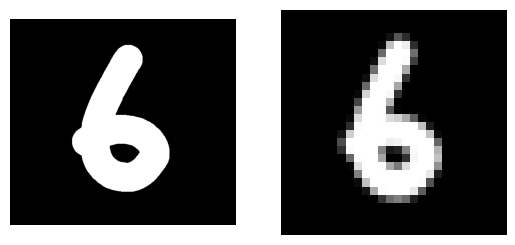

In [19]:
plt.subplot(1,2,1) #create subplot first
plt.imshow(image, cmap='gray')
plt.axis('off')

#dimensions need to be correct
plt.subplot(1,2,2)
plt.imshow(pixelated_image_visual, cmap='gray')
plt.axis('off') 

plt.show() #not needed for Jupyter